Anchored Ensembling - Regression Example in PyTorch

In [211]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_optimizer as th_optim


In [319]:
# NN options
n_ensemble = 5	# no. NNs in ensemble
reg = 'free'		# type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 64 	# no. hidden units in NN
activation_in = 'relu' # tanh relu sigmoid
data_noise = 0.001 # estimated noise variance
n_data = 80

# optimisation options
epochs = 3000 		# run reg for 15+ epochs seems to mess them up
l_rate = 0.1 		# learning rate

# variance of priors
W1_var = 20/1		# 1st layer weights and biases
W_last_var = 1/n_hidden	# final layer weights

# convert variance to lambdas
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var

In [320]:
def fn_make_data():
    # create some data
    x_train = np.atleast_2d(np.random.rand(n_data)).T * 1.5#np.atleast_2d([1., 4.5, 5.1, 6., 8., 9.]).T
    x_train = x_train/1 - 1
    y_train = 10*x_train * np.sin(x_train*5.) + np.exp(2*x_train)*x_train

    # create validation data - here we'll just a 1-d grid
    x_val = np.atleast_2d(np.linspace(-3, 3, 100)).T
    y_val = np.expand_dims(x_val[:,0],1) # just dummy data
    
    return x_train, y_train, x_val, y_val

In [321]:
def add_noise_to_weights(model, scale=0.08):
    print('add noise to weight')
    with torch.no_grad():
        for param in model.parameters():
            param.add_(torch.randn(param.size()) * scale)

class EnsembleModels(object):
    
    def __init__(self, n_ensemble=5,
                reg='free',
                n_hidden=64,
                activation_in='relu',
                D_in=1,
                D_out=1):
        super(EnsembleModels, self).__init__()
        self.n_ensemble = n_ensemble
        self.reg = reg
        self.n_hidden = n_hidden
        self.activation_in = activation_in
        self.D_in = D_in
        self.D_out = D_out

        # create the NNs
        self.NNs=[]
        for m in range(self.n_ensemble):
            self.NNs.append(self.fn_make_simple_NN(activation_in=self.activation_in))
            #NNs.append(fn_make_NN(activation_in=activation_in))

    
    def fn_make_NN(self, activation_in='relu'):
        D_in, D_out = self.D_in, self.D_out # input and output dimension

        if activation_in == 'relu':
            mid_act = torch.nn.ReLU()
        elif activation_in == 'tanh':
            mid_act = torch.nn.Tanh()
        elif activation_in == 'sigmoid':
            mid_act = torch.nn.Sigmoid()

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, n_hidden),
            mid_act,
            torch.nn.Linear(n_hidden, D_out, bias=False),
        )

        # initialise weights
        model[0].weight.data.normal_(0.0, np.sqrt(W1_var))
        model[0].bias.data.normal_(0.0, np.sqrt(b1_var))
        model[2].weight.data.normal_(0.0, np.sqrt(W_last_var))

        return model

    def fn_make_simple_NN(self, activation_in='relu'):
        D_in, D_out = self.D_in, self.D_out # input and output dimension
        n_hidden = self.n_hidden
        if activation_in == 'relu':
            mid_act = torch.nn.ReLU()
        elif activation_in == 'tanh':
            mid_act = torch.nn.Tanh()
        elif activation_in == 'sigmoid':
            mid_act = torch.nn.Sigmoid()

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, n_hidden),
            mid_act,
            torch.nn.utils.spectral_norm(torch.nn.Linear(n_hidden, n_hidden)),
            #torch.nn.Dropout(0.1),
            mid_act,

            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Dropout(0.1),
            mid_act,

            #torch.nn.utils.spectral_norm(torch.nn.Linear(n_hidden, D_out, bias=True)),
            torch.nn.Linear(n_hidden, D_out, bias=True),
            #torch.nn.Dropout(0.1),
        )

        return model

    def fn_predict_ensemble(self, x_test):
        ''' fn to predict given a list of NNs (an ensemble)''' 
        y_preds = []
        for m in range(self.n_ensemble):
            y_preds.append(self.NNs[m](torch.tensor(x_test).float()).data.numpy())
        y_preds = np.array(y_preds)

        y_preds_mu = np.mean(y_preds,axis=0)
        y_preds_std = np.std(y_preds,axis=0)

        return y_preds, y_preds_mu, y_preds_std

In [322]:
# create some data
x_train, y_train, x_test, y_test = fn_make_data()

EM = EnsembleModels(n_ensemble=n_ensemble,
                    reg='free',
                    n_hidden=128,
                    activation_in='relu',
                    D_in=1,
                    D_out=1)
print(EM.NNs[0])

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=1, bias=True)
)


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


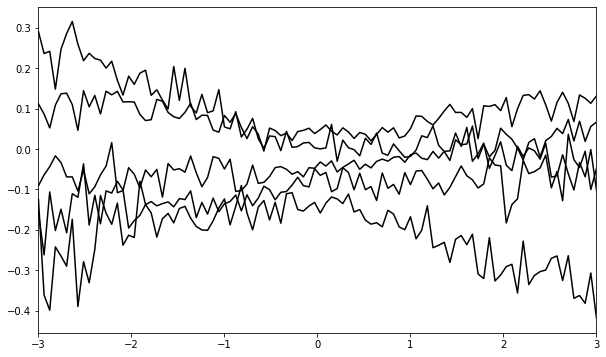

In [323]:
# plot priors
y_preds, y_preds_mu, y_preds_std = EM.fn_predict_ensemble(x_test)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in range(0,EM.n_ensemble):
     ax.plot(x_test, y_preds[m], 'k')
ax.set_xlim(-3, 3)
fig.show()

In [324]:


for tmp in range(1):
    # do training
    x_train, y_train, x_test, y_test = fn_make_data()
    x = torch.tensor(x_train).float()
    y = torch.tensor(y_train).float()
    NNs_hist_train=[];
    for m in range(EM.n_ensemble):
        print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
        add_noise_to_weights(EM.NNs[m], scale=0.3)
        # set up loss
        loss_fn = torch.nn.MSELoss(reduction='sum')
        #optimizer = torch.optim.Adam(EM.NNs[m].parameters(), lr=l_rate)
        #"""
        opt_yogi = th_optim.Yogi(
            EM.NNs[m].parameters(),
            lr= 1e-2,
            betas=(0.9, 0.999),
            eps=1e-3,
            initial_accumulator=1e-6,
            weight_decay=0,
        )

        optimizer = th_optim.Lookahead(opt_yogi,  alpha=0.5)#k=5
        #"""
        # set anchoring points (different set for each NN)
        W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_hidden,1])
        b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
        W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[1,n_hidden])
        W1_anc = torch.tensor(W1_anc).float()
        b1_anc = torch.tensor(b1_anc).float()
        W_last_anc = torch.tensor(W_last_anc).float()

        NNs_losses=[]
        for _ in range(epochs):
            y_pred = EM.NNs[m](x)
            #loss = loss_fn(y_pred, y)
            loss = ((y_pred-y)**2).mean()

            # set up reg loss
            l2 = 0
            if reg == 'anc':
                l2 += W1_lambda/n_data * torch.mul(NNs[m][0].weight - W1_anc, NNs[m][0].weight - W1_anc).sum()
                l2 += b1_lambda/n_data * torch.mul(NNs[m][0].bias - b1_anc, NNs[m][0].bias - b1_anc).sum()
                l2 += W_last_lambda/n_data * torch.mul(NNs[m][2].weight - W_last_anc, NNs[m][2].weight - W_last_anc).sum()
            elif reg == 'reg':
                l2 += W1_lambda/n_data * torch.mul(NNs[m][0].weight, NNs[m][0].weight).sum()
                l2 += b1_lambda/n_data * torch.mul(NNs[m][0].bias, NNs[m][0].bias).sum()
                l2 += W_last_lambda/n_data * torch.mul(NNs[m][2].weight, NNs[m][2].weight).sum()
            elif reg == 'free':
                # do nothing
                l2 += 0.0
            loss = loss + l2

            # run gradient update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            NNs_losses.append(loss.item())
        NNs_hist_train.append(NNs_losses)

-- training: 1 of 5 NNs --
add noise to weight
-- training: 2 of 5 NNs --
add noise to weight
-- training: 3 of 5 NNs --
add noise to weight
-- training: 4 of 5 NNs --
add noise to weight
-- training: 5 of 5 NNs --
add noise to weight


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


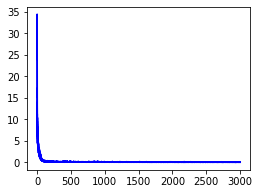

In [325]:
# check how training looked
NNs_hist_train=np.array(NNs_hist_train)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
for m in range(EM.n_ensemble):
    ax.plot(NNs_hist_train[m], color='b',label='train')
fig.show()

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


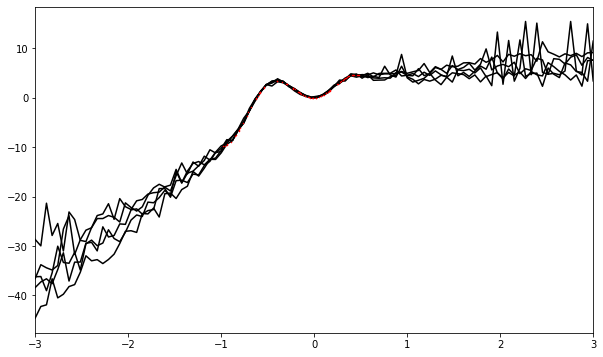

In [326]:
# run predictions
y_preds, y_preds_mu, y_preds_std = EM.fn_predict_ensemble(x_test)

# plot predictions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in range(0,EM.n_ensemble):
    ax.plot(x_test, y_preds[m], 'k')
ax.plot(x_train[:,0], y_train, 'r.', markersize=3,
        markeredgecolor='k',markeredgewidth=0.)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


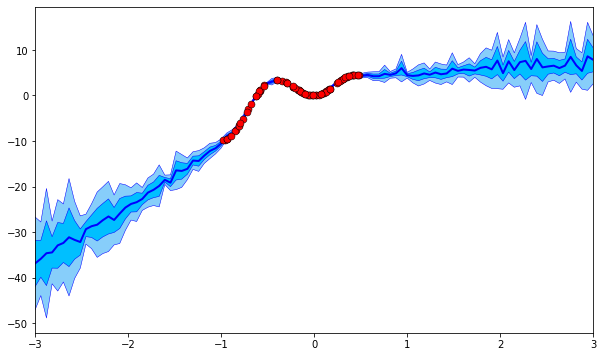

In [327]:
# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()

In [84]:
# see how it looks for different prior variance and data noise
activation_in = 'tanh'
data_noise = 0.02
W1_var = 0.2

# convert variance to lambdas
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var

# create the NNs
NNs=[]
#for m in range(n_ensemble):
	#NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
for m in range(n_ensemble):
    NNs.append(fn_make_NN(activation_in=activation_in))

# do training
for m in range(n_ensemble):
    print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
    
    # set up loss
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(NNs[m].parameters(), lr=l_rate)
    
    # set anchoring points (different set for each NN)
    W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_hidden,1])
    b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
    W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[1,n_hidden])
    W1_anc = torch.tensor(W1_anc).float()
    b1_anc = torch.tensor(b1_anc).float()
    W_last_anc = torch.tensor(W_last_anc).float()

    for _ in range(epochs):
        y_pred = NNs[m](x)
        #loss = loss_fn(y_pred, y)
        loss = ((y_pred-y)**2).mean()
        
        # set up reg loss
        l2 = 0
        if reg == 'anc':
            l2 += W1_lambda/n_data * torch.mul(NNs[m][0].weight - W1_anc, NNs[m][0].weight - W1_anc).sum()
            l2 += b1_lambda/n_data * torch.mul(NNs[m][0].bias - b1_anc, NNs[m][0].bias - b1_anc).sum()
            l2 += W_last_lambda/n_data * torch.mul(NNs[m][2].weight - W_last_anc, NNs[m][2].weight - W_last_anc).sum()
        elif reg == 'reg':
            l2 += W1_lambda/n_data * torch.mul(NNs[m][0].weight, NNs[m][0].weight).sum()
            l2 += b1_lambda/n_data * torch.mul(NNs[m][0].bias, NNs[m][0].bias).sum()
            l2 += W_last_lambda/n_data * torch.mul(NNs[m][2].weight, NNs[m][2].weight).sum()
        elif reg == 'free':
            # do nothing
            l2 += 0.0
        loss = loss + l2
        
        # run gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# run predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()

NameError: name 'fn_make_NN' is not defined

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


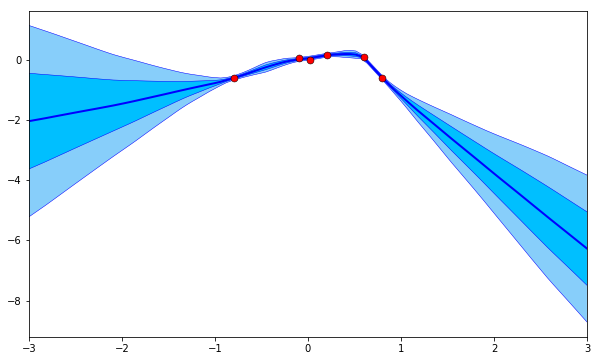

In [444]:
# see how it looks for relu
activation_in = 'relu'
data_noise = 0.001
W1_var = 10

# convert variance to lambdas
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var

# create the NNs
NNs=[]
#for m in range(n_ensemble):
	#NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
for m in range(n_ensemble):
    NNs.append(fn_make_NN(activation_in=activation_in))

# do training
for m in range(n_ensemble):
    print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
    
    # set up loss
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(NNs[m].parameters(), lr=l_rate)
    
    # set anchoring points (different set for each NN)
    W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_hidden,1])
    b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
    W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[1,n_hidden])
    W1_anc = torch.tensor(W1_anc).float()
    b1_anc = torch.tensor(b1_anc).float()
    W_last_anc = torch.tensor(W_last_anc).float()

    for _ in range(epochs):
        y_pred = NNs[m](x)
        #loss = loss_fn(y_pred, y)
        loss = ((y_pred-y)**2).mean()
        
        # set up reg loss
        l2 = 0
        if reg == 'anc':
            l2 += W1_lambda/n_data * torch.mul(NNs[m][0].weight - W1_anc, NNs[m][0].weight - W1_anc).sum()
            l2 += b1_lambda/n_data * torch.mul(NNs[m][0].bias - b1_anc, NNs[m][0].bias - b1_anc).sum()
            l2 += W_last_lambda/n_data * torch.mul(NNs[m][2].weight - W_last_anc, NNs[m][2].weight - W_last_anc).sum()
        elif reg == 'reg':
            l2 += W1_lambda/n_data * torch.mul(NNs[m][0].weight, NNs[m][0].weight).sum()
            l2 += b1_lambda/n_data * torch.mul(NNs[m][0].bias, NNs[m][0].bias).sum()
            l2 += W_last_lambda/n_data * torch.mul(NNs[m][2].weight, NNs[m][2].weight).sum()
        elif reg == 'free':
            # do nothing
            l2 += 0.0
        loss = loss + l2
        
        # run gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# run predictions
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
# ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
fig.show()